# IST652 - Scripting for Data Analysis
## Jim Hwang, Woojin Park, Chiau Yin Yang
## LDA Topic Modeling using Spark (*Env:Databricks)

#Install Packages

In [3]:
%sh /databricks/python/bin/python -m pip install nltk

Collecting nltk
 Downloading https://files.pythonhosted.org/packages/73/56/90178929712ce427ebad179f8dc46c8deef4e89d4c853092bee1efd57d05/nltk-3.4.1.zip (3.1MB)
Requirement already satisfied: six in /usr/lib/python3/dist-packages (from nltk) (1.10.0)
Building wheels for collected packages: nltk
 Building wheel for nltk (setup.py): started
 Building wheel for nltk (setup.py): finished with status 'done'
 Stored in directory: /root/.cache/pip/wheels/97/8a/10/d646015f33c525688e91986c4544c68019b19a473cb33d3b55
Successfully built nltk
Installing collected packages: nltk
Successfully installed nltk-3.4.1

In [4]:
%sh /databricks/python/bin/python -m pip install --upgrade pip stopwords

Requirement already up-to-date: pip in /databricks/python3/lib/python3.5/site-packages (19.1)
Requirement already up-to-date: stopwords in /databricks/python3/lib/python3.5/site-packages (0.1.3)

#Import Libraries

In [6]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from pyspark.ml import classification
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
from matplotlib.pyplot import pie, axis, show
import seaborn as sns
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
from nltk.corpus import stopwords
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

In [7]:
%fs ls FileStore/tables

path,name,size
dbfs:/FileStore/tables/01_01.sql,01_01.sql,1258
dbfs:/FileStore/tables/01_03.sql,01_03.sql,1158
dbfs:/FileStore/tables/LISTING417.csv,LISTING417.csv,21278642
dbfs:/FileStore/tables/a_new.csv,a_new.csv,134965971
dbfs:/FileStore/tables/airbnb_final_2__1_-599f7.ipynb,airbnb_final_2__1_-599f7.ipynb,20656
dbfs:/FileStore/tables/articles1.csv,articles1.csv,203539364
dbfs:/FileStore/tables/bankdata_csv_all.csv,bankdata_csv_all.csv,34566
dbfs:/FileStore/tables/cogsley_clients.csv,cogsley_clients.csv,384219
dbfs:/FileStore/tables/cogsley_sales.csv,cogsley_sales.csv,2176442
dbfs:/FileStore/tables/detailed_listings-347ac.csv,detailed_listings-347ac.csv,182544196


#Read the dataset

In [9]:
pandas_df = pd.read_csv("/dbfs/FileStore/tables/a_new.csv", error_bad_lines=False, encoding = "ISO-8859-1")

pandas_df

Out[ 13 ]: 
 id title \
0 17376 2 Credit-Reporting Agencies Must Pay $23 Milli... 
1 21332 Harley-Davidson to Pay $12 Million Fine in Pol... 
2 22414 Regulator Tightens Control Over Wells Fargo - ... 
3 23396 Pope Francis Says Church Should Apologize to G... 
4 26539 CNNâs Zeleny: âHard to Imagineâ Obama Wo... 
5 26540 American Students on Spring Break Chant âBui... 
6 26541 Surge in âHonour Crimesâ and Forced Marria... 
7 26542 MILO Announces New Media Venture - Breitbart 
8 26545 Watch: Celebrities Beg Congress to âObstruct... 
9 26548 Drug Stocks Drop as Trump Backs Price Bidding 
10 26549 New Orleans Removes Famous âLee Circleâ Mo... 
11 26550 Two Helicopters, FBI Bomb Squad Called Out At ... 
12 26551 James Cameron Slams Trumpâs Administration: ... 
13 26552 House Freedom Caucus Saved GOP Majority from R... 
14 26553 NYT: Immigration Hard-Liners Rising in Trump A... 
15 26555 Trump Celebrates Americaâs Faith-Based Found... 
16 26556 Report: Illegal Aliens Forego Food Stamps to S... 
17 26557 MILO Fan at UW Appears Covered in Bruises, Cut... 
18 26558 âDistressâ But No Apology For Epiphany Ser... 
19 26559 Kentucky Rep. Thomas Massie Launches Bill to A... 
20 26560 âSNLâ Star Michael Che Not Sorry for Calli... 
21 26562 Exclusive â Leading Trumpocrat: Time for Pau... 
22 26563 Report: Personal Info of Nearly 200 Million Vo... 
23 26564 Kellogg Announces Job Cuts, Closures, Slashes ... 
24 26565 Brokaw: âDemocrats Have a Lot of Reconstruct... 
25 26566 FS1âs Cowherd, Whitlock to Pro Leagues: Donâ... 
26 26567 Jerry Seinfeld: I Donât Get the âBig Dealâ... 
27 26568 Police: Thieves Botch ATM Burglary Attempt, Ac... 
28 26569 J Scott Armstrong: Fewer Than 1 Percent Of Pap... 
29 26570 Watch: Celebrities Narrate Animated History of... 
... ... ... 
36738 217105 Journalists shouldnÃ¢â¬â¢t try to win a popu... 
36739 217106 Trump is right not to go after Hillary Clinton... 
36740 217158 On Thanksgiving, what it means to be the city ... 
36741 217181 âPizzagateâ shows how fake news hurts real... 
36742 217208 Fidel Castroâs terrible legacy 
36743 217259 Trumpâs ânewsâ source: Alien lizards, fl... 
36744 217282 The election really was rigged 
36745 217310 Stick a sterling silver fork in Trumpâs âp... 
36746 217314 Democrats should pick their health-care battles 
36747 217336 Beware: The Russian bear is getting bolder 
36748 217361 Trump, the pleaser president 
36749 217390 Massachusetts firefighters battle large Cambri... 
36750 217434 In Trumpâs America, âpizzagateâ could be... 
36751 217463 Trumpâs one consistent policy: Chaos 
36752 217468 A false victory at Standing Rock 
36753 217488 Kellyanne Conway is playing the âwoman cardâ... 
36754 217543 How Schumer and the Democrats are preparing to... 
36755 217544 A man who rejects settled science on climate c... 
36756 217666 The (fake) news about Melania Trump 
36757 217812 Trump voters didnât take him literally on Ob... 
36758 217836 James Comeyâs year of unintended â and rui... 
36759 217838 Germans face a new threat â and their democr... 
36760 217840 The Trump family must make clear that influenc... 
36761 217867 Australian police say they prevented bombings ... 
36762 217892 The Obama administration fires a dangerous par... 
36763 217913 Some lessons from Jesus, for all of us 
36764 217970 Venezuela is lurching closer and closer to chaos 
36765 217995 As Trump prepares his kissy face for Putin, a ... 
36766 218071 Hamilton helped elect his rival to keep an â... 
36767 218074 Trump refuses to face reality about Russia 

 publication author date year month \
0 New York Times Reuters 2017-01-03 2017.0 1.0 
1 New York Times Reuters 2016-08-22 2016.0 8.0 
2 New York Times Reuters 2017-04-08 2017.0 4.0 
3 New York Times Reuters 2016-06-28 2016.0 6.0 
4 Breitbart Ian Hanchett 2017-01-17 2017.0 1.0 
5 Breitbart Katherine Rodriguez 2017-03-21 2017.0 3.0 
6 Breitbart Liam Deacon 2017-04-08 2017.0 4.0 
7 Breitb

# Start descriptive analysis

In [11]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36768 entries, 0 to 36767
Data columns (total 8 columns):
id 36768 non-null int64
title 36768 non-null object
publication 36768 non-null object
author 36768 non-null object
date 36768 non-null object
year 36768 non-null float64
month 36768 non-null float64
content 36768 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 2.2+ MB

In [12]:
pandas_df.head()

Out[ 15 ]: 
 id title publication \
0 17376 2 Credit-Reporting Agencies Must Pay $23 Milli... New York Times 
1 21332 Harley-Davidson to Pay $12 Million Fine in Pol... New York Times 
2 22414 Regulator Tightens Control Over Wells Fargo - ... New York Times 
3 23396 Pope Francis Says Church Should Apologize to G... New York Times 
4 26539 CNNâs Zeleny: âHard to Imagineâ Obama Wo... Breitbart 

 author date year month \
0 Reuters 2017-01-03 2017.0 1.0 
1 Reuters 2016-08-22 2016.0 8.0 
2 Reuters 2017-04-08 2017.0 4.0 
3 Reuters 2016-06-28 2016.0 6.0 
4 Ian Hanchett 2017-01-17 2017.0 1.0 

 content 
0 The nationâs consumer watchdog agency on Tue... 
1 WASHINGTON â has agreed to pay a $12 mi... 
2 A leading bank regulator on Friday reversed co... 
3 Pope Francis said on Sunday that Christians an... 
4 On Tuesdayâs broadcast of CNNâs âSituati...

In [13]:
pandas_df.describe(include='all')

Out[ 16 ]: 
 id title publication \
count 36768.000000 36768 36768 
unique NaN 36727 11 
top NaN The Atlanticâs Week in Culture Breitbart 
freq NaN 11 19029 
mean 86380.320741 NaN NaN 
std 57618.566999 NaN NaN 
min 17376.000000 NaN NaN 
25% 38062.750000 NaN NaN 
50% 49540.500000 NaN NaN 
75% 134566.250000 NaN NaN 
max 218074.000000 NaN NaN 

 author date year month content 
count 36768 36768 36768.000000 36768.000000 36768 
unique 119 1174 NaN NaN 36701 
top Breitbart News 2016-09-02 NaN NaN advertisement 
freq 1559 104 NaN NaN 42 
mean NaN NaN 2016.335863 5.529781 NaN 
std NaN NaN 0.497319 3.352693 NaN 
min NaN NaN 2003.000000 1.000000 NaN 
25% NaN NaN 2016.000000 3.000000 NaN 
50% NaN NaN 2016.000000 5.000000 NaN 
75% NaN NaN 2017.000000 8.000000 NaN 
max NaN NaN 2017.000000 12.000000 NaN

In [14]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36768 entries, 0 to 36767
Data columns (total 8 columns):
id 36768 non-null int64
title 36768 non-null object
publication 36768 non-null object
author 36768 non-null object
date 36768 non-null object
year 36768 non-null float64
month 36768 non-null float64
content 36768 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 2.2+ MB

In [15]:
a2_agg = pandas_df.groupby(['publication','author']).count().sort_values('id',ascending=False)
a2_agg2 = a2_agg[a2_agg['content'] >= 150]
a2_agg2.head(2)

Out[ 18 ]: 
 id title date year month content
publication author 
Breitbart Breitbart News 1559 1559 1559 1559 1559 1559
 Pam Key 1282 1282 1282 1282 1282 1282

In [16]:
a2_agg.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 126 entries, (Breitbart, Breitbart News) to (Vox, Danielle Kurtzleben)
Data columns (total 6 columns):
id 126 non-null int64
title 126 non-null int64
date 126 non-null int64
year 126 non-null int64
month 126 non-null int64
content 126 non-null int64
dtypes: int64(6)
memory usage: 7.4+ KB

In [17]:
pandas_df["content_clean"] = pandas_df["content"].str.lower().str.split()

In [18]:
pandas_df.head(5)

Out[ 24 ]: 
 id title publication \
0 17376 2 Credit-Reporting Agencies Must Pay $23 Milli... New York Times 
1 21332 Harley-Davidson to Pay $12 Million Fine in Pol... New York Times 
2 22414 Regulator Tightens Control Over Wells Fargo - ... New York Times 
3 23396 Pope Francis Says Church Should Apologize to G... New York Times 
4 26539 CNNâs Zeleny: âHard to Imagineâ Obama Wo... Breitbart 

 author date year month \
0 Reuters 2017-01-03 2017.0 1.0 
1 Reuters 2016-08-22 2016.0 8.0 
2 Reuters 2017-04-08 2017.0 4.0 
3 Reuters 2016-06-28 2016.0 6.0 
4 Ian Hanchett 2017-01-17 2017.0 1.0 

 content \
0 The nationâs consumer watchdog agency on Tue... 
1 WASHINGTON â has agreed to pay a $12 mi... 
2 A leading bank regulator on Friday reversed co... 
3 Pope Francis said on Sunday that Christians an... 
4 On Tuesdayâs broadcast of CNNâs âSituati... 

 content_clean 
0 [the, nationâs, consumer, watchdog, agency, ... 
1 [washington, â, has, agreed, to, pay, a, $12... 
2 [a, leading, bank, regulator, on, friday, reve... 
3 [pope, francis, said, on, sunday, that, christ... 
4 [on, tuesdayâs, broadcast, of, cnnâs, âs...

# Start Spark Session

In [20]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [21]:
spark_df = sqlContext.createDataFrame(pandas_df)


In [22]:
spark_df.printSchema()

root
-- id: long (nullable = true)
-- title: string (nullable = true)
-- publication: string (nullable = true)
-- author: string (nullable = true)
-- date: string (nullable = true)
-- year: double (nullable = true)
-- month: double (nullable = true)
-- content: string (nullable = true)
-- content_clean: array (nullable = true)
 |-- element: string (containsNull = true)

# Get brief idea abstract of NPR data

In [24]:
spark_df.where(fn.col('publication') == 'NPR').show()

+------+--------------------+-----------+-------------------+----------+------+-----+--------------------+
 id| title|publication| author| date| year|month| content|
+------+--------------------+-----------+-------------------+----------+------+-----+--------------------+
160642|Trump Tweets Give...| NPR| Jessica Taylor|2016-12-28|2016.0| 12.0| Donald Trump ha...|
160644|Putin Says Russia...| NPR| Camila Domonoske|2016-12-30|2016.0| 12.0|Updated at 2:50 p...|
160649|When Bats Squeak,...| NPR| NPR Staff|2016-12-31|2016.0| 12.0|If movies were tr...|
160654|Behold: Susan Sta...| NPR| NPR Staff|2016-12-31|2016.0| 12.0|For the last inst...|
160659|On The Men Who Ra...| NPR| NPR Staff|2016-12-30|2016.0| 12.0|David Bowie, Prin...|
160677|To Appeal To A Mo...| NPR| NPR Staff|2017-01-01|2017.0| 1.0|If you find yours...|
160682|For These Three T...| NPR| NPR Staff|2017-01-01|2017.0| 1.0|By day, Nicola Be...|
160698|GOP Leaders Ready...| NPR| Jessica Taylor|2017-01-02|2017.0| 1.0|As the 115th Cong...|
160739|WATCH: Time-Lapse...| NPR| Merrit Kennedy|2017-01-03|2017.0| 1.0|Beijingâs sky a...|
160741|Nonreligious Amer...| NPR|Danielle Kurtzleben|2017-01-03|2017.0| 1.0|One in five Ameri...|
160742|Turkey Arrests Su...| NPR| Merrit Kennedy|2017-01-03|2017.0| 1.0|Updated at 1 p. m...|
160749|âIâm Not Goin...| NPR| Colin Dwyer|2017-01-04|2017.0| 1.0|Dylann Roof deliv...|
160750|More Than 100 Peo...| NPR| Merrit Kennedy|2017-01-04|2017.0| 1.0|A crowded commute...|
160751|Amid Ethics Offic...| NPR|Danielle Kurtzleben|2017-01-04|2017.0| 1.0|Amid this weekâ...|
160757|Civil Rights Acti...| NPR| Camila Domonoske|2017-01-04|2017.0| 1.0|Several civil rig...|
160761|Israeli Soldier C...| NPR| Camila Domonoske|2017-01-04|2017.0| 1.0|An Israeli milita...|
160775|A Big Fish Sells ...| NPR| Colin Dwyer|2017-01-05|2017.0| 1.0|Just before dawn ...|
160777|Mystery Radio Wav...| NPR| Merrit Kennedy|2017-01-05|2017.0| 1.0|Unexplained, shor...|
160785|New Guidelines Te...| NPR| Rebecca Hersher|2017-01-05|2017.0| 1.0|After multiple re...|
160786|Obama To The Amer...| NPR| Camila Domonoske|2017-01-05|2017.0| 1.0|As President Obam...|
+------+--------------------+-----------+-------------------+----------+------+-----+--------------------+
only showing top 20 rows

In [25]:
spark_df.where(fn.col('publication') == 'NPR').count()

Out[ 34 ]: 2822

In [26]:
npr = spark_df.where(fn.col('publication') == 'NPR')
npr.count()

Out[ 35 ]: 2822

In [27]:
npr.groupBy('publication').agg(fn.count('*')).show()

+-----------+--------+
publication|count(1)|
+-----------+--------+
 NPR| 2822|
+-----------+--------+

In [28]:
training_df, testing_df = npr.randomSplit([0.6, 0.4], seed=0)

In [29]:
[training_df.count(),testing_df.count()]

Out[ 38 ]: [1716, 1106]

# Topic Modeling _ Do data cleaning & preparation

In [31]:
from pyspark.ml.feature import RegexTokenizer

#Tokenize the Text

In [33]:
tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("content")\
  .setOutputCol("words")

In [34]:
content_words_df = tokenizer.transform(training_df)
print(content_words_df)

DataFrame[id: bigint, title: string, publication: string, author: string, date: string, year: double, month: double, content: string, words: array<string>]

In [35]:
content_words_df.show(5)

+------+--------------------+-----------+-------------------+----------+------+-----+--------------------+--------------------+
 id| title|publication| author| date| year|month| content| words|
+------+--------------------+-----------+-------------------+----------+------+-----+--------------------+--------------------+
160642|Trump Tweets Give...| NPR| Jessica Taylor|2016-12-28|2016.0| 12.0| Donald Trump ha...|[donald, trump, h...|
160649|When Bats Squeak,...| NPR| NPR Staff|2016-12-31|2016.0| 12.0|If movies were tr...|[if, movies, were...|
160654|Behold: Susan Sta...| NPR| NPR Staff|2016-12-31|2016.0| 12.0|For the last inst...|[for, the, last, ...|
160741|Nonreligious Amer...| NPR|Danielle Kurtzleben|2017-01-03|2017.0| 1.0|One in five Ameri...|[one, in, five, a...|
160742|Turkey Arrests Su...| NPR| Merrit Kennedy|2017-01-03|2017.0| 1.0|Updated at 1 p. m...|[updated, at, p, ...|
+------+--------------------+-----------+-------------------+----------+------+-----+--------------------+--------------------+
only showing top 5 rows

# Stop words remove

In [37]:
import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
stop_words[0:10]

Out[ 44 ]: 
['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost']

In [38]:
from pyspark.ml.feature import StopWordsRemover
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

# TF-IDF

In [40]:
from pyspark.ml.feature import CountVectorizer

# we will remove words that appear in 5 docs or less
cv = CountVectorizer(minTF=1., minDF=5., vocabSize=2**17)\
  .setInputCol("filtered")\
  .setOutputCol("tf")

In [41]:
# we now create a pipelined transformer
cv_pipeline = Pipeline(stages=[tokenizer, sw_filter, cv]).fit(training_df)

In [42]:
cv_pipeline.transform(training_df).show(5)

+------+--------------------+-----------+-------------------+----------+------+-----+--------------------+--------------------+--------------------+--------------------+
 id| title|publication| author| date| year|month| content| words| filtered| tf|
+------+--------------------+-----------+-------------------+----------+------+-----+--------------------+--------------------+--------------------+--------------------+
160642|Trump Tweets Give...| NPR| Jessica Taylor|2016-12-28|2016.0| 12.0| Donald Trump ha...|[donald, trump, h...|[donald, trump, u...|(10312,[0,1,2,3,6...|
160649|When Bats Squeak,...| NPR| NPR Staff|2016-12-31|2016.0| 12.0|If movies were tr...|[if, movies, were...|[movies, trying, ...|(10312,[0,1,3,5,7...|
160654|Behold: Susan Sta...| NPR| NPR Staff|2016-12-31|2016.0| 12.0|For the last inst...|[for, the, last, ...|[installment, npr...|(10312,[1,9,10,11...|
160741|Nonreligious Amer...| NPR|Danielle Kurtzleben|2017-01-03|2017.0| 1.0|One in five Ameri...|[one, in, five, a...|[americans, relig...|(10312,[0,1,2,3,4...|
160742|Turkey Arrests Su...| NPR| Merrit Kennedy|2017-01-03|2017.0| 1.0|Updated at 1 p. m...|[updated, at, p, ...|[updated, p, m, e...|(10312,[0,1,4,5,1...|
+------+--------------------+-----------+-------------------+----------+------+-----+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [43]:
len(cv_pipeline.stages[-1].vocabulary)

Out[ 49 ]: 10312

In [44]:
from pyspark.ml.feature import IDF
idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

In [45]:
idf_pipeline = Pipeline(stages=[cv_pipeline, idf]).fit(training_df)

In [46]:
idf_pipeline.transform(training_df).show(5)

+------+--------------------+-----------+-------------------+----------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
 id| title|publication| author| date| year|month| content| words| filtered| tf| tfidf|
+------+--------------------+-----------+-------------------+----------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
160642|Trump Tweets Give...| NPR| Jessica Taylor|2016-12-28|2016.0| 12.0| Donald Trump ha...|[donald, trump, h...|[donald, trump, u...|(10312,[0,1,2,3,6...|(10312,[0,1,2,3,6...|
160649|When Bats Squeak,...| NPR| NPR Staff|2016-12-31|2016.0| 12.0|If movies were tr...|[if, movies, were...|[movies, trying, ...|(10312,[0,1,3,5,7...|(10312,[0,1,3,5,7...|
160654|Behold: Susan Sta...| NPR| NPR Staff|2016-12-31|2016.0| 12.0|For the last inst...|[for, the, last, ...|[installment, npr...|(10312,[1,9,10,11...|(10312,[1,9,10,11...|
160741|Nonreligious Amer...| NPR|Danielle Kurtzleben|2017-01-03|2017.0| 1.0|One in five Ameri...|[one, in, five, a...|[americans, relig...|(10312,[0,1,2,3,4...|(10312,[0,1,2,3,4...|
160742|Turkey Arrests Su...| NPR| Merrit Kennedy|2017-01-03|2017.0| 1.0|Updated at 1 p. m...|[updated, at, p, ...|[updated, p, m, e...|(10312,[0,1,4,5,1...|(10312,[0,1,4,5,1...|
+------+--------------------+-----------+-------------------+----------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [47]:
tfidf_df = idf_pipeline.transform(training_df)

In [48]:
tfidf_df.select('tfidf').collect()

Out[ 54 ]: 
[Row(tfidf=SparseVector(10312, {0: 0.1368, 1: 0.1292, 2: 1.3213, 3: 1.143, 6: 18.9068, 7: 0.5476, 8: 8.4575, 9: 0.625, 10: 0.7451, 11: 1.3991, 12: 1.8817, 13: 2.0697, 14: 1.1276, 17: 2.6282, 23: 0.9884, 24: 1.1494, 27: 1.1549, 31: 1.1792, 32: 0.7955, 42: 5.116, 44: 1.4977, 45: 1.1294, 46: 1.328, 54: 1.3503, 56: 2.5743, 58: 5.6745, 59: 2.8257, 63: 1.6106, 67: 1.4444, 72: 3.9437, 73: 1.3084, 81: 1.401, 82: 2.0367, 88: 1.5241, 96: 1.4297, 97: 1.5484, 98: 1.7118, 102: 1.4899, 105: 1.7994, 108: 1.5847, 118: 1.5539, 120: 3.3663, 121: 1.911, 123: 5.0968, 125: 1.5403, 129: 3.6777, 131: 3.9271, 135: 1.8064, 140: 1.8316, 142: 1.8425, 145: 2.3303, 146: 1.7379, 157: 1.9269, 158: 1.8611, 164: 3.2804, 165: 1.8877, 166: 1.6958, 168: 3.2804, 172: 8.1112, 180: 1.7215, 185: 2.1805, 189: 2.1108, 191: 2.0502, 200: 3.986, 212: 2.1651, 214: 4.6369, 216: 1.8724, 229: 8.8476, 236: 2.3732, 255: 2.0684, 256: 1.9635, 262: 2.0731, 265: 2.0684, 267: 2.2013, 277: 2.8432, 286: 2.0593, 291: 1.9887, 299: 21.2065, 300: 4.7842, 317: 4.038, 321: 2.3985, 322: 2.15, 336: 4.5331, 342: 2.3008, 350: 2.1702, 357: 4.5108, 359: 7.3332, 363: 4.3713, 367: 2.2722, 370: 2.2554, 375: 4.985, 378: 2.4114, 398: 2.3669, 419: 2.3303, 458: 2.3184, 462: 2.5963, 463: 2.6862, 464: 2.3732, 495: 2.3607, 497: 2.3485, 502: 2.4716, 516: 2.4377, 559: 2.4716, 564: 2.3794, 573: 5.3723, 586: 2.8532, 595: 2.5357, 598: 2.7034, 678: 2.8332, 690: 2.8532, 696: 2.5808, 734: 3.0416, 748: 21.9849, 754: 2.905, 755: 2.8532, 756: 12.6315, 766: 2.8634, 791: 3.8107, 819: 2.8945, 899: 2.7662, 910: 3.4593, 916: 2.8532, 939: 3.0663, 940: 2.9265, 953: 2.8736, 954: 2.8945, 961: 3.0663, 1010: 2.9824, 1042: 2.9824, 1043: 3.2142, 1074: 2.994, 1110: 3.1579, 1113: 3.1998, 1144: 3.1998, 1186: 3.1443, 1220: 3.0663, 1256: 3.1579, 1273: 3.3375, 1364: 10.2689, 1379: 3.2587, 1408: 3.893, 1460: 4.0471, 1595: 3.7595, 1609: 3.6197, 1745: 4.081, 1783: 3.3375, 1803: 3.5165, 1839: 3.4593, 1859: 3.9826, 1860: 3.6417, 1929: 3.5165, 1990: 8.0943, 1991: 3.6871, 2024: 3.7848, 2062: 3.5565, 2245: 4.0471, 2406: 3.7107, 2414: 8.7146, 2590: 4.0143, 2594: 4.1902, 2613: 3.8107, 2626: 4.1161, 2675: 4.0471, 2710: 8.0943, 2735: 4.1161, 2778: 4.0143, 2791: 4.0143, 2805: 4.081, 2862: 3.893, 2925: 4.1161, 2966: 3.9518, 3064: 8.0287, 3152: 4.3573, 3252: 4.0471, 3380: 5.1457, 3419: 4.4526, 3442: 4.081, 3472: 4.4038, 3479: 9.4806, 3496: 14.8903, 3520: 9.9269, 3543: 4.1161, 3674: 9.3515, 3724: 4.6757, 3787: 4.4038, 3826: 4.6757, 3849: 5.1457, 3898: 4.3128, 3930: 4.2295, 3990: 4.6151, 4055: 4.6151, 4220: 4.6757, 4230: 4.3573, 4250: 4.3128, 4271: 5.2511, 4380: 4.8093, 4414: 4.6757, 4420: 4.4038, 4715: 4.4526, 4790: 4.5039, 4808: 4.5039, 4970: 18.9611, 5113: 10.5022, 5155: 4.6151, 5286: 4.8093, 5543: 4.7403, 5544: 4.8834, 5680: 4.8093, 5720: 4.7403, 6388: 4.8834, 6613: 5.0504, 6626: 4.9634, 7062: 5.1457, 7135: 5.0504, 7322: 5.3689, 7475: 5.1457, 7534: 5.1457, 7574: 5.1457, 7786: 5.1457, 7825: 5.2511, 7847: 5.2511, 7881: 5.6566, 7950: 5.2511, 8784: 5.3689, 8893: 5.3689, 8918: 5.3689, 8919: 5.5024, 8948: 5.5024, 9166: 5.5024, 9312: 5.5024, 9776: 5.6566, 10150: 5.6566, 10242: 5.6566})),
 Row(tfidf=SparseVector(10312, {0: 0.2736, 1: 0.038, 3: 0.762, 5: 3.5636, 7: 2.1904, 9: 0.625, 10: 1.4903, 11: 0.6996, 12: 1.2545, 15: 1.1366, 22: 2.6492, 29: 2.0469, 30: 1.0235, 31: 1.1792, 32: 0.7955, 33: 1.3939, 39: 1.2787, 43: 1.2999, 54: 1.3503, 59: 1.4129, 68: 1.5348, 70: 1.6523, 73: 1.3084, 76: 1.3962, 109: 1.6492, 111: 1.472, 114: 1.5819, 126: 1.7313, 156: 2.0234, 163: 1.8064, 173: 1.9269, 180: 1.7215, 194: 6.1505, 196: 1.7446, 205: 1.7716, 219: 2.0824, 221: 3.6851, 223: 4.1185, 233: 1.9719, 234: 1.9032, 239: 2.0234, 247: 3.822, 253: 2.145, 288: 2.1702, 289: 2.1108, 293: 2.0965, 298: 2.0965, 316: 2.0547, 332: 7.0638, 340: 2.2778, 352: 2.1205, 365: 8.3547, 374: 2.295, 438: 8.4701, 440: 4.6848, 447: 2.3008, 465: 2.7388, 466: 2.4444, 499: 2.4785, 523: 18.1051, 543: 2.905, 595: 2.5357, 605: 7.5851, 666: 2.6121, 672: 7.9329, 717: 2.7034, 722: 5.4597, 745: 

In [49]:
tfidf = Pipeline(stages=[tokenizer, sw_filter, cv, idf]).fit(training_df)

In [50]:
tfidf.transform(training_df).show()

+------+--------------------+-----------+-------------------+----------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
 id| title|publication| author| date| year|month| content| words| filtered| tf| tfidf|
+------+--------------------+-----------+-------------------+----------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
160642|Trump Tweets Give...| NPR| Jessica Taylor|2016-12-28|2016.0| 12.0| Donald Trump ha...|[donald, trump, h...|[donald, trump, u...|(10312,[0,1,2,3,6...|(10312,[0,1,2,3,6...|
160649|When Bats Squeak,...| NPR| NPR Staff|2016-12-31|2016.0| 12.0|If movies were tr...|[if, movies, were...|[movies, trying, ...|(10312,[0,1,3,5,7...|(10312,[0,1,3,5,7...|
160654|Behold: Susan Sta...| NPR| NPR Staff|2016-12-31|2016.0| 12.0|For the last inst...|[for, the, last, ...|[installment, npr...|(10312,[1,9,10,11...|(10312,[1,9,10,11...|
160741|Nonreligious Amer...| NPR|Danielle Kurtzleben|2017-01-03|2017.0| 1.0|One in five Ameri...|[one, in, five, a...|[americans, relig...|(10312,[0,1,2,3,4...|(10312,[0,1,2,3,4...|
160742|Turkey Arrests Su...| NPR| Merrit Kennedy|2017-01-03|2017.0| 1.0|Updated at 1 p. m...|[updated, at, p, ...|[updated, p, m, e...|(10312,[0,1,4,5,1...|(10312,[0,1,4,5,1...|
160750|More Than 100 Peo...| NPR| Merrit Kennedy|2017-01-04|2017.0| 1.0|A crowded commute...|[a, crowded, comm...|[crowded, commute...|(10312,[0,1,2,3,4...|(10312,[0,1,2,3,4...|
160751|Amid Ethics Offic...| NPR|Danielle Kurtzleben|2017-01-04|2017.0| 1.0|Amid this weekâ...|[amid, this, week...|[amid, weekâ, s, ...|(10312,[0,1,3,4,6...|(10312,[0,1,3,4,6...|
160757|Civil Rights Acti...| NPR| Camila Domonoske|2017-01-04|2017.0| 1.0|Several civil rig...|[several, civil, ...|[civil, rights, a...|(10312,[0,1,2,5,8...|(10312,[0,1,2,5,8...|
160777|Mystery Radio Wav...| NPR| Merrit Kennedy|2017-01-05|2017.0| 1.0|Unexplained, shor...|[unexplained, sho...|[unexplained, sho...|(10312,[0,1,3,5,7...|(10312,[0,1,3,5,7...|
160786|Obama To The Amer...| NPR| Camila Domonoske|2017-01-05|2017.0| 1.0|As President Obam...|[as, president, o...|[president, obama...|(10312,[0,1,2,3,4...|(10312,[0,1,2,3,4...|
160798|Putin Ordered â...| NPR| Merrit Kennedy|2017-01-06|2017.0| 1.0|Updated 5:30 p. m...|[updated, p, m, e...|[updated, p, m, e...|(10312,[0,1,2,5,6...|(10312,[0,1,2,5,6...|
160808|On This German Is...| NPR| Colin Dwyer|2017-01-06|2017.0| 1.0|Itâs a fantasy ...|[itâ, s, a, fanta...|[itâ, s, fantasy,...|(10312,[0,1,2,7,9...|(10312,[0,1,2,7,9...|
160813|The xx On Growing...| NPR| NPR Staff|2017-01-06|2017.0| 1.0|Maintaining a r...|[maintaining, a, ...|[maintaining, rel...|(10312,[0,1,4,5,9...|(10312,[0,1,4,5,9...|
160816|âComfort Womanâ...| NPR| Merrit Kennedy|2017-01-06|2017.0| 1.0|A golden statue c...|[a, golden, statu...|[golden, statue, ...|(10312,[0,1,2,5,1...|(10312,[0,1,2,5,1...|
160819|Tilikum, SeaWorld...| NPR| Camila Domonoske|2017-01-06|2017.0| 1.0|Tilikum, possibly...|[tilikum, possibl...|[tilikum, possibl...|(10312,[0,1,2,5,1...|(10312,[0,1,2,5,1...|
160820|Soldiers Seize Iv...| NPR| Rebecca Hersher|2017-01-06|2017.0| 1.0|Officials in the ...|[officials, in, t...|[officials, west,...|(10312,[0,1,2,3,4...|(10312,[0,1,2,3,4...|
160825|Norway Will Be Fi...| NPR| Camila Domonoske|2017-01-06|2017.0| 1.0|Starting next wee...|[starting, next, ...|[starting, week, ...|(10312,[0,1,2,3,4...|(10312,[0,1,2,3,4...|
160826|After Prison, A M...| NPR| NPR Staff|2017-01-06|2017.0| 1.0|When Kayla Wilson...|[when, kayla, wil...|[kayla, wilson, m...|(10312,[0,1,2,3,4...|(10312,[0,1,2,3,4...|
160827|What Kind Of âJ...| NPR|Danielle Kurtzleben|2017-01-07|2017.0| 1.0|The final chapter...|[the, final, chap...|[final, chapter, ...|(10312,[0,1,3,4,6...|(10312,[0,1,3,4,6...|
160871|Trump Names Son-I...| NPR|Danielle Kurtzleben|2017-01-09|2017.0| 1.0|Donald Trump has ...|[donald, trump, h...|[donald, trump, n...|(10312,[0,1,

In [51]:
tfidf_sample = tfidf.transform(training_df).first().tfidf

In [52]:
tfidf_sample

Out[ 58 ]: SparseVector(10312, {0: 0.1368, 1: 0.1292, 2: 1.3213, 3: 1.143, 6: 18.9068, 7: 0.5476, 8: 8.4575, 9: 0.625, 10: 0.7451, 11: 1.3991, 12: 1.8817, 13: 2.0697, 14: 1.1276, 17: 2.6282, 23: 0.9884, 24: 1.1494, 27: 1.1549, 31: 1.1792, 32: 0.7955, 42: 5.116, 44: 1.4977, 45: 1.1294, 46: 1.328, 54: 1.3503, 56: 2.5743, 58: 2.8257, 59: 5.6745, 63: 1.6106, 67: 1.4444, 72: 3.9437, 73: 1.3084, 81: 1.401, 82: 2.0367, 88: 1.5241, 96: 1.4297, 97: 1.5484, 98: 1.7118, 102: 1.4899, 105: 1.7994, 108: 1.5847, 119: 1.5539, 120: 3.3663, 121: 1.911, 123: 5.0968, 125: 1.5403, 129: 3.6777, 131: 3.9271, 135: 1.8064, 140: 1.8316, 142: 1.8425, 145: 2.3303, 146: 1.7379, 157: 1.9269, 158: 1.8611, 164: 3.2804, 165: 1.8877, 166: 1.6958, 167: 3.2804, 172: 8.1112, 182: 1.7215, 185: 2.1805, 189: 2.1108, 191: 2.0502, 200: 3.986, 211: 2.1651, 215: 4.6369, 217: 1.8724, 230: 8.8476, 236: 2.3732, 255: 2.0684, 256: 1.9635, 262: 2.0731, 265: 2.0684, 266: 2.2013, 277: 2.8432, 286: 2.0593, 291: 1.9887, 299: 21.2065, 300: 4.7842, 317: 4.038, 319: 2.3985, 322: 2.15, 337: 4.5331, 342: 2.3008, 351: 2.1702, 357: 4.5108, 360: 7.3332, 363: 4.3713, 369: 2.2722, 370: 2.2554, 376: 4.985, 379: 2.4114, 396: 2.3669, 419: 2.3303, 454: 2.3184, 462: 2.3732, 464: 2.5963, 465: 2.6862, 495: 2.3607, 497: 2.3485, 502: 2.4716, 517: 2.4377, 559: 2.4716, 564: 2.3794, 574: 5.3723, 587: 2.8532, 595: 2.5357, 598: 2.7034, 680: 2.8332, 688: 2.8532, 694: 2.5808, 732: 3.0416, 749: 21.9849, 756: 2.905, 757: 2.8532, 758: 12.6315, 769: 2.8634, 792: 3.8107, 821: 2.8945, 902: 2.7662, 912: 3.4593, 917: 2.8532, 939: 3.0663, 943: 2.9265, 954: 2.8736, 955: 2.8945, 963: 3.0663, 1011: 2.9824, 1043: 2.9824, 1047: 3.2142, 1077: 2.994, 1114: 3.1579, 1116: 3.1998, 1148: 3.1998, 1188: 3.1443, 1216: 3.0663, 1250: 3.1579, 1280: 3.3375, 1372: 10.2689, 1379: 3.2587, 1408: 3.893, 1460: 4.0471, 1592: 3.7595, 1615: 3.6197, 1755: 4.081, 1776: 3.3375, 1808: 3.5165, 1846: 3.4593, 1864: 3.9826, 1865: 3.6417, 1932: 3.5165, 1998: 8.0943, 1999: 3.6871, 2024: 3.7848, 2061: 3.5565, 2275: 4.0471, 2403: 8.7146, 2415: 3.7107, 2583: 3.8107, 2601: 4.0143, 2605: 4.1902, 2648: 4.1161, 2681: 4.0471, 2725: 8.0943, 2736: 4.1161, 2757: 4.0143, 2790: 4.0143, 2803: 4.081, 2827: 3.893, 2964: 4.1161, 2980: 3.9518, 3064: 8.0287, 3136: 4.3573, 3220: 4.0471, 3433: 4.4526, 3449: 5.1457, 3458: 4.081, 3472: 4.4038, 3479: 14.8903, 3523: 9.4806, 3530: 4.1161, 3533: 9.9269, 3708: 9.3515, 3709: 4.6757, 3777: 4.6757, 3842: 5.1457, 3843: 4.4038, 3886: 4.2295, 3970: 4.6151, 3998: 4.3128, 4068: 4.6151, 4157: 4.6757, 4167: 4.3573, 4182: 4.3128, 4194: 5.2511, 4316: 4.8093, 4426: 4.6757, 4429: 4.4038, 4644: 4.4526, 4763: 4.5039, 4812: 4.5039, 4933: 18.9611, 5008: 10.5022, 5236: 4.6151, 5310: 4.8093, 5403: 4.8834, 5443: 4.7403, 5615: 4.8093, 5736: 4.7403, 6351: 4.8834, 6599: 5.0504, 6803: 4.9634, 7072: 5.1457, 7201: 5.0504, 7356: 5.1457, 7494: 5.3689, 7662: 5.1457, 7697: 5.1457, 7789: 5.1457, 8049: 5.2511, 8109: 5.2511, 8167: 5.6566, 8185: 5.2511, 8408: 5.5024, 8482: 5.3689, 8521: 5.3689, 8580: 5.3689, 8596: 5.5024, 9305: 5.5024, 9579: 5.5024, 9670: 5.6566, 9804: 5.6566, 10290: 5.6566})

In [53]:
from pyspark.ml.linalg import Vectors

# Make them into Dense Vecotors

In [55]:
Vectors.dense(tfidf_sample)

Out[ 60 ]: DenseVector([0.1368, 0.1292, 1.3213, 1.143, 0.0, 0.0, 18.9068, 0.5476, 8.4575, 0.625, 0.7451, 1.3991, 1.8817, 2.0697, 1.1276, 0.0, 0.0, 2.6282, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9884, 1.1494, 0.0, 0.0, 1.1549, 0.0, 0.0, 0.0, 1.1792, 0.7955, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.116, 0.0, 1.4977, 1.1294, 1.328, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3503, 0.0, 2.5743, 0.0, 2.8257, 5.6745, 0.0, 0.0, 0.0, 1.6106, 0.0, 0.0, 0.0, 1.4444, 0.0, 0.0, 0.0, 0.0, 3.9437, 1.3084, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.401, 2.0367, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5241, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4297, 1.5484, 1.7118, 0.0, 0.0, 0.0, 1.4899, 0.0, 0.0, 1.7994, 0.0, 0.0, 1.5847, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5539, 3.3663, 1.911, 0.0, 5.0968, 0.0, 1.5403, 0.0, 0.0, 0.0, 3.6777, 0.0, 3.9271, 0.0, 0.0, 0.0, 1.8064, 0.0, 0.0, 0.0, 0.0, 1.8316, 0.0, 1.8425, 0.0, 0.0, 2.3303, 1.7379, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.9269, 1.8611, 0.0, 0.0, 0.0, 0.0, 0.0, 3.2804, 1.8877, 1.6958, 3.2804, 0.0, 0.0, 0.0, 0.0, 8.1112, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7215, 0.0, 0.0, 2.1805, 0.0, 0.0, 0.0, 2.1108, 0.0, 2.0502, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.986, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1651, 0.0, 0.0, 0.0, 4.6369, 0.0, 1.8724, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.8476, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3732, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0684, 1.9635, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0731, 0.0, 0.0, 2.0684, 2.2013, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8432, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0593, 0.0, 0.0, 0.0, 0.0, 1.9887, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.2065, 4.7842, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.038, 0.0, 2.3985, 0.0, 0.0, 2.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.5331, 0.0, 0.0, 0.0, 0.0, 2.3008, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1702, 0.0, 0.0, 0.0, 0.0, 0.0, 4.5108, 0.0, 0.0, 7.3332, 0.0, 0.0, 4.3713, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2722, 2.2554, 0.0, 0.0, 0.0, 0.0, 0.0, 4.985, 0.0, 0.0, 2.4114, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3669, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3303, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3184, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3732, 0.0, 2.5963, 2.6862, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3607, 0.0, 2.3485, 0.0, 0.0, 0.0, 0.0, 2.4716, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4377, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4716, 0.0, 0.0, 0.0, 0.0, 2.3794, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.3723, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8532, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5357, 0.0, 0.0, 2.7034, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8532, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5808, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [56]:
type(Vectors.dense(tfidf_sample))

Out[ 61 ]: pyspark.ml.linalg.DenseVector

# pyspark.ml.linalg.DenseVector because that's what Spark ML expects

In [58]:
def to_dense(sparse_vector):
    return Vectors.dense(sparse_vector)

In [59]:
to_dense(tfidf_sample)

Out[ 63 ]: DenseVector([0.1368, 0.1292, 1.3213, 1.143, 0.0, 0.0, 18.9068, 0.5476, 8.4575, 0.625, 0.7451, 1.3991, 1.8817, 2.0697, 1.1276, 0.0, 0.0, 2.6282, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9884, 1.1494, 0.0, 0.0, 1.1549, 0.0, 0.0, 0.0, 1.1792, 0.7955, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.116, 0.0, 1.4977, 1.1294, 1.328, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3503, 0.0, 2.5743, 0.0, 2.8257, 5.6745, 0.0, 0.0, 0.0, 1.6106, 0.0, 0.0, 0.0, 1.4444, 0.0, 0.0, 0.0, 0.0, 3.9437, 1.3084, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.401, 2.0367, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5241, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4297, 1.5484, 1.7118, 0.0, 0.0, 0.0, 1.4899, 0.0, 0.0, 1.7994, 0.0, 0.0, 1.5847, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5539, 3.3663, 1.911, 0.0, 5.0968, 0.0, 1.5403, 0.0, 0.0, 0.0, 3.6777, 0.0, 3.9271, 0.0, 0.0, 0.0, 1.8064, 0.0, 0.0, 0.0, 0.0, 1.8316, 0.0, 1.8425, 0.0, 0.0, 2.3303, 1.7379, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.9269, 1.8611, 0.0, 0.0, 0.0, 0.0, 0.0, 3.2804, 1.8877, 1.6958, 3.2804, 0.0, 0.0, 0.0, 0.0, 8.1112, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7215, 0.0, 0.0, 2.1805, 0.0, 0.0, 0.0, 2.1108, 0.0, 2.0502, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.986, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1651, 0.0, 0.0, 0.0, 4.6369, 0.0, 1.8724, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.8476, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3732, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0684, 1.9635, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0731, 0.0, 0.0, 2.0684, 2.2013, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8432, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0593, 0.0, 0.0, 0.0, 0.0, 1.9887, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.2065, 4.7842, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.038, 0.0, 2.3985, 0.0, 0.0, 2.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.5331, 0.0, 0.0, 0.0, 0.0, 2.3008, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1702, 0.0, 0.0, 0.0, 0.0, 0.0, 4.5108, 0.0, 0.0, 7.3332, 0.0, 0.0, 4.3713, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2722, 2.2554, 0.0, 0.0, 0.0, 0.0, 0.0, 4.985, 0.0, 0.0, 2.4114, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3669, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3303, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3184, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3732, 0.0, 2.5963, 2.6862, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3607, 0.0, 2.3485, 0.0, 0.0, 0.0, 0.0, 2.4716, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4377, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4716, 0.0, 0.0, 0.0, 0.0, 2.3794, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.3723, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8532, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5357, 0.0, 0.0, 2.7034, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8532, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5808, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [60]:
from pyspark.ml.linalg import VectorUDT

In [61]:
to_dense_udf = fn.udf(to_dense, VectorUDT())

In [62]:
tfidf.transform(training_df).select('tfidf', to_dense_udf('tfidf').alias('dense_tfidf')).show()

+--------------------+--------------------+
 tfidf| dense_tfidf|
+--------------------+--------------------+
(10312,[0,1,2,3,6...|[0.13680276314786...|
(10312,[0,1,3,5,7...|[0.27360552629572...|
(10312,[1,9,10,11...|[0.0,0.0152003070...|
(10312,[0,1,2,3,4...|[0.15200307016429...|
(10312,[0,1,4,5,1...|[0.07600153508214...|
(10312,[0,1,2,3,4...|[0.12160245613143...|
(10312,[0,1,3,4,6...|[0.09880199560678...|
(10312,[0,1,2,5,8...|[0.23560475875465...|
(10312,[0,1,3,5,7...|[0.20520414472179...|
(10312,[0,1,2,3,4...|[0.19760399121357...|
(10312,[0,1,2,5,6...|[0.21280429823000...|
(10312,[0,1,2,7,9...|[0.04560092104928...|
(10312,[0,1,4,5,9...|[0.15200307016429...|
(10312,[0,1,2,5,1...|[0.13680276314786...|
(10312,[0,1,2,5,1...|[0.15200307016429...|
(10312,[0,1,2,3,4...|[0.13680276314786...|
(10312,[0,1,2,3,4...|[0.11400230262321...|
(10312,[0,1,2,3,4...|[0.19000383770536...|
(10312,[0,1,3,4,6...|[0.14440291665607...|
(10312,[0,1,2,3,4...|[0.20520414472179...|
+--------------------+--------------------+
only showing top 20 rows

In [63]:
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param


class Densify(Transformer, HasInputCol, HasOutputCol):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, stopwords=None):
        super(Densify, self).__init__()
        self._setDefault()
#         print(self._input_kwargs)
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def _transform(self, dataset):
        out_col = self.getOutputCol()
        in_col = dataset[self.getInputCol()]
        return dataset.withColumn(out_col, to_dense_udf(in_col))

# Apply Densify Class to get Dense tfidf

In [65]:
dense_tfidf = Densify(inputCol='tfidf', outputCol='dense_tfidf')

In [66]:
pipeline2_model = Pipeline(stages=[tokenizer, sw_filter, cv, idf, dense_tfidf]).fit(training_df)
pipeline2_model.transform(training_df).select('tfidf', 'dense_tfidf').show()

+--------------------+--------------------+
 tfidf| dense_tfidf|
+--------------------+--------------------+
(10312,[0,1,2,3,6...|[0.13680276314786...|
(10312,[0,1,3,5,7...|[0.27360552629572...|
(10312,[1,9,10,11...|[0.0,0.0152003070...|
(10312,[0,1,2,3,4...|[0.15200307016429...|
(10312,[0,1,4,5,1...|[0.07600153508214...|
(10312,[0,1,2,3,4...|[0.12160245613143...|
(10312,[0,1,3,4,6...|[0.09880199560678...|
(10312,[0,1,2,5,8...|[0.23560475875465...|
(10312,[0,1,3,5,7...|[0.20520414472179...|
(10312,[0,1,2,3,4...|[0.19760399121357...|
(10312,[0,1,2,5,6...|[0.21280429823000...|
(10312,[0,1,2,7,9...|[0.04560092104928...|
(10312,[0,1,4,5,9...|[0.15200307016429...|
(10312,[0,1,2,5,1...|[0.13680276314786...|
(10312,[0,1,2,5,1...|[0.15200307016429...|
(10312,[0,1,2,3,4...|[0.13680276314786...|
(10312,[0,1,2,3,4...|[0.11400230262321...|
(10312,[0,1,2,3,4...|[0.19000383770536...|
(10312,[0,1,3,4,6...|[0.14440291665607...|
(10312,[0,1,2,3,4...|[0.20520414472179...|
+--------------------+--------------------+
only showing top 20 rows

# Define More Pipelines (Centered, Normalized, Kmeans, LDA)

In [68]:
center = feature.StandardScaler(withMean=True, withStd=False, inputCol='dense_tfidf', outputCol='centered_tfidf')

In [69]:
norm = feature.Normalizer(inputCol="centered_tfidf", outputCol="norm_tfidf", p=2.0)

In [70]:
kmeans = clustering.KMeans(k=5, featuresCol='norm_tfidf', predictionCol='kmeans_feat')

In [71]:
lda = clustering.LDA(k=4, featuresCol='tfidf', topicDistributionCol='lda_feat')

In [72]:
final_pipeline = Pipeline(stages=[tokenizer, sw_filter, cv, idf, dense_tfidf, center, norm, kmeans, lda])

# Having the final pipeline model

In [74]:
pipeline_model = final_pipeline.fit(training_df)

In [75]:
pipeline_model.transform(training_df).show(5)

+------+--------------------+-----------+-------------------+----------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+
 id| title|publication| author| date| year|month| content| words| filtered| tf| tfidf| dense_tfidf| centered_tfidf| norm_tfidf|kmeans_feat| lda_feat|
+------+--------------------+-----------+-------------------+----------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+
160642|Trump Tweets Give...| NPR| Jessica Taylor|2016-12-28|2016.0| 12.0| Donald Trump ha...|[donald, trump, h...|[donald, trump, u...|(10312,[0,1,2,3,6...|(10312,[0,1,2,3,6...|[0.13680276314786...|[-0.0363354658399...|[-4.9211428405198...| 4|[0.05803437597041...|
160649|When Bats Squeak,...| NPR| NPR Staff|2016-12-31|2016.0| 12.0|If movies were tr...|[if, movies, were...|[movies, trying, ...|(10312,[0,1,3,5,7...|(10312,[0,1,3,5,7...|[0.27360552629572...|[0.10046729730788...|[0.00137826259749...| 1|[3.83265410091288...|
160654|Behold: Susan Sta...| NPR| NPR Staff|2016-12-31|2016.0| 12.0|For the last inst...|[for, the, last, ...|[installment, npr...|(10312,[1,9,10,11...|(10312,[1,9,10,11...|[0.0,0.0152003070...|[-0.1731382289878...|[-0.0033497983098...| 2|[8.86383766732127...|
160741|Nonreligious Amer...| NPR|Danielle Kurtzleben|2017-01-03|2017.0| 1.0|One in five Ameri...|[one, in, five, a...|[americans, relig...|(10312,[0,1,2,3,4...|(10312,[0,1,2,3,4...|[0.15200307016429...|[-0.0211351588235...|[-2.9316840575152...| 4|[3.01511923548746...|
160742|Turkey Arrests Su...| NPR| Merrit Kennedy|2017-01-03|2017.0| 1.0|Updated at 1 p. m...|[updated, at, p, ...|[updated, p, m, e...|(10312,[0,1,4,5,1...|(10312,[0,1,4,5,1...|[0.07600153508214...|[-0.0971366939056...|[-0.0015746520996...| 1|[0.76947225612021...|
+------+--------------------+-----------+-------------------+----------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+
only showing top 5 rows

# Topic Modeling Interpretation : LDA

In [77]:
lda_model = pipeline_model.stages[-1]

In [78]:
lda_model.describeTopics(maxTermsPerTopic=20).show()

+-----+--------------------+--------------------+
topic| termIndices| termWeights|
+-----+--------------------+--------------------+
 0|[28, 512, 65, 160...|[0.00377516688541...|
 1|[6, 15, 4, 529, 3...|[0.00309867298578...|
 2|[6, 36, 153, 34, ...|[0.00503798666778...|
 3|[1704, 101, 299, ...|[0.00412668718754...|
+-----+--------------------+--------------------+

In [79]:
terms_matrix = np.array(lda_model.describeTopics(20).rdd.map(lambda x: x['termIndices']).collect())

In [80]:
vocabulary = pipeline_model.stages[2].vocabulary

# Output of 4 Topic group's best 20 term Matrix

In [82]:
np.array(vocabulary)[terms_matrix]

Out[ 109 ]: 
array([['police', 'comey', 'court', 'investigation', 'trump', 'law',
 'president', 'case', 'said', 'reports', 'u', 'justice', 'russia',
 'state', 'fbi', 'reported', 'judge', 'city', 'rights', 'department'],
 ['trump', 'think', 'people', 'suicide', 'really', 'attack', 'iâ',
 'u', 'know', 'like', 'man', 'kind', 'trumpâ', 'just', 'british',
 'book', 'm', 't', 'lot', 'world'],
 ['trump', 'clinton', 'sanders', 'percent', 'voters', 'music',
 'vote', 'jobs', 'women', 'election', 'cruz', 'campaign',
 'republicans', 'gop', 'democratic', 'republican', 'americans',
 'democrats', 'itâ', 't'],
 ['greenland', 'water', 'china', 'pipeline', 'says', 'company',
 'food', 'arctic', 'miles', 'researchers', 'inuit', 'feet', 'oil',
 'species', 'native', 'storm', 'scientists', 'island', 'animal',
 'space']], 
 dtype='<U18')

In [83]:
Topic0 = np.array(vocabulary)[terms_matrix][0].tolist()
Topic1 = np.array(vocabulary)[terms_matrix][1].tolist()
Topic2 = np.array(vocabulary)[terms_matrix][2].tolist()
Topic3 = np.array(vocabulary)[terms_matrix][3].tolist()

In [84]:
df1 = pd.DataFrame({'Topic0':Topic0})
df2 = pd.DataFrame({'Topic1':Topic1})
df3 = pd.DataFrame({'Topic2':Topic2})
df4 = pd.DataFrame({'Topic3':Topic3})

Out[ 134 ]: 
 Topic2
0 trump
1 clinton
2 sanders
3 percent
4 voters
5 music
6 vote
7 jobs
8 women
9 election
10 cruz
11 campaign
12 republicans
13 gop
14 democratic
15 republican
16 americans
17 democrats
18 itâ
19 t

In [85]:
Topic_df = pd.concat([df1.T,df2.T,df3.T,df4.T])


Out[ 135 ]: 
 0 1 2 3 4 5 \
Topic0 police comey court investigation trump law 
Topic1 trump think people suicide really attack 
Topic2 trump clinton sanders percent voters music 
Topic3 greenland water china pipeline says company 

 6 7 8 9 10 11 12 \
Topic0 president case said reports u justice russia 
Topic1 iâ u know like man kind trumpâ 
Topic2 vote jobs women election cruz campaign republicans 
Topic3 food arctic miles researchers inuit feet oil 

 13 14 15 16 17 18 \
Topic0 state fbi reported judge city rights 
Topic1 just british book m t lot 
Topic2 gop democratic republican americans democrats itâ 
Topic3 species native storm scientists island animal 

 19 
Topic0 department 
Topic1 world 
Topic2 t 
Topic3 space

In [86]:
Topic_df.T

Out[ 137 ]: 
 Topic0 Topic1 Topic2 Topic3
0 police trump trump greenland
1 comey think clinton water
2 court people sanders china
3 investigation suicide percent pipeline
4 trump really voters says
5 law attack music company
6 president iâ vote food
7 case u jobs arctic
8 said know women miles
9 reports like election researchers
10 u man cruz inuit
11 justice kind campaign feet
12 russia trumpâ republicans oil
13 state just gop species
14 fbi british democratic native
15 reported book republican storm
16 judge m americans scientists
17 city t democrats island
18 rights lot itâ animal
19 department world t space

In [87]:
kmeans_df = pipeline_model.transform(training_df)

In [88]:
kmeans_df.groupBy('kmeans_feat').agg(fn.count('*')).show()

+-----------+--------+
kmeans_feat|count(1)|
+-----------+--------+
 1| 1125|
 3| 4|
 4| 265|
 2| 132|
 0| 190|
+-----------+--------+

#Convert Spart Dataframe Output into Pandas Dataframe

In [90]:
Fianl_pandas =pipeline_model.transform(training_df).toPandas()

# Frequency distribution of Each Topic group

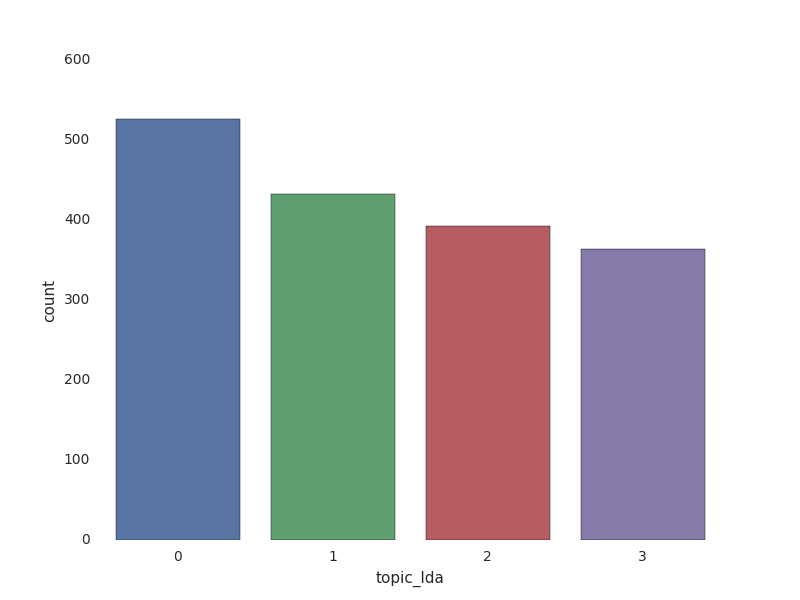

In [92]:
TopicNumber=[]
for i in range(len(Fianl_pandas['lda_feat'])):
    h=Fianl_pandas['lda_feat'][i].tolist().index(Fianl_pandas['lda_feat'][i].max())
    TopicNumber.append(h)
    
Fianl_pandas['topic_lda']=TopicNumber



f,ax=plt.subplots(figsize=(8,6))

aa=sns.countplot(x='topic_lda', data=Fianl_pandas)
display()

# kmeans group (centroids = 5)

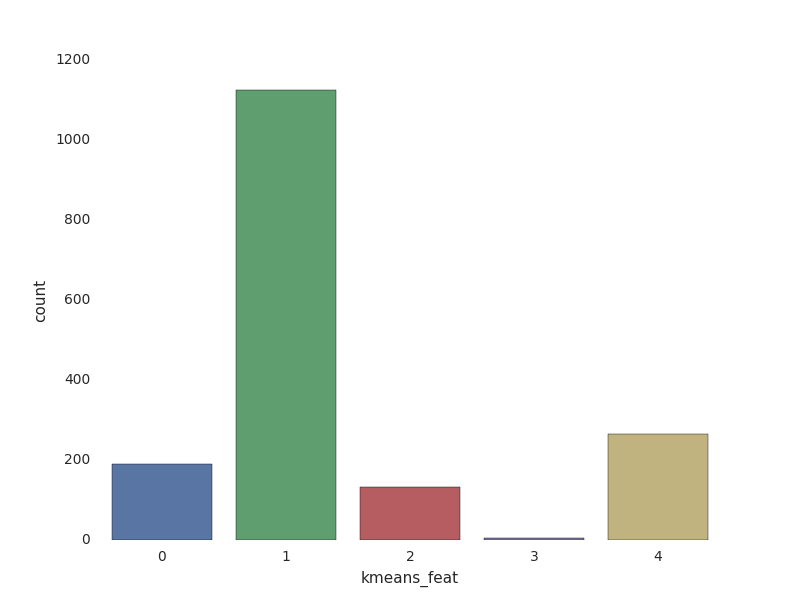

In [94]:
f,ax=plt.subplots(figsize=(8,6))
a=sns.countplot(x='kmeans_feat',data=Fianl_pandas,ax=ax)
display()

In [95]:
Fianl_pandas